# ADF for inference.
Start with explaining the core sampling operations:
1. Convolution of gaussians.
2. Greater than operator.

## Convolution.
\begin{align}
Skill & \sim \mathcal{N}(Skill;\ \mu_s,\,\sigma_s) \\
Performance & \sim \mathcal{N}(Performance;\ Skill,\,\sigma_p) \\
\end{align}

A player's $Skill$ is Normally distributed around a mean skill $\mu_s$ with uncertainity(*standard deviation*) $\sigma_s$. For a completely unknown player, the uncertainity will be large before the evaluation begins and will eventually decrease. A player's performance on game day can vary based on a number of external factors, all of which are assumed to be incorporated in a player's $Performance$ which is also normally distributed around his $Skill$. The uncertainity($\sigma_p$) around the performance can be interpreted as a player's consistency. A consistent player will more often than not, exhibit a performance which is very close to his true skill.

### - Numerical(quantised) computation.
Obtaining a distribution over a player's $Performance: Perf_i$ is straightforward. Seed the player's $Skill: Skill_i$ with a mean and std. Then sample from $Skill_i$. Every $j^{th}$ sampled skill $Skill^j_i$ will serve as the mean for a performance variable $Perf^j_i$. Averaging all performances will give the approximated distribution over the performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
from scipy.stats import norm

In [16]:
s1 = norm(4, np.sqrt(9))

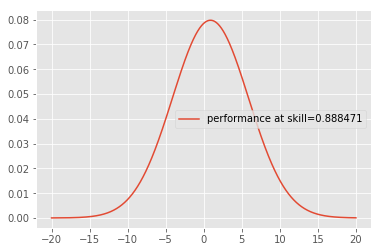

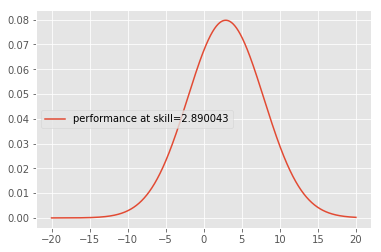

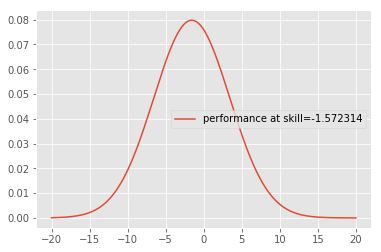

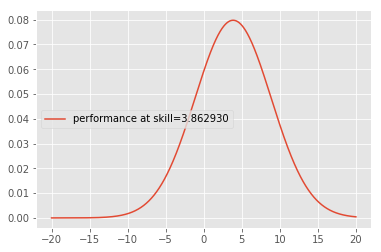

In [21]:
arr = []
for ix in range(100):    
    vs1 = s1.rvs()
    xs1 = np.linspace(-20, 20, 5000)
    
    p1 = norm(vs1, np.sqrt(25))
    vp1 = p1.rvs()
    xp1 = np.linspace(-20, 20, 5000)
    
    arr.append(p1.pdf(xp1))
    
    if ix%25==0:
        plt.figure()
        plt.plot(xp1, p1.pdf(xp1), label="performance at skill=%f"%vs1)
        plt.legend()

Peak at: 3.87677535507


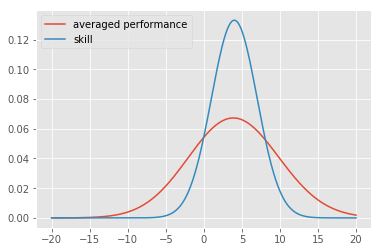

In [22]:
avg = np.mean(np.array(arr), axis=0)
plt.plot(xp1, avg, label="averaged performance")
plt.plot(xs1, s1.pdf(xs1), label="skill")
plt.legend();

print "Peak at:", xp1[np.argmax(avg)]

The approximate mean turns out to be 3.844

### - Analytic computation.
For a more concrete example, arrive at the marginal distribution $p(e)$ given:

\begin{align}
p(s) & = \mathcal{N}(s;\ \mu_a,\,\sigma_a^2) \\
p(e|s) & = \mathcal{N}(e;\ s,\,\sigma_b^2) \\
\end{align}

If the joint distribution over $e, s$ is factorised as $p(e|s) p(s)$, then the expression for the marginal becomes:
$$ p(s) = \int_s\ p(e|s)\ p(s)\ ds $$